<h2>Group 4 Sentiment Analysis</h2>

<h3>When doing the scalability analysis, the code was only to code cell number 3</h3>

In [1]:
import findspark
findspark.init("/home/ubuntu/spark-3.3.2-bin-hadoop3")
findspark.find()

'/home/ubuntu/spark-3.3.2-bin-hadoop3'

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
 
spark = SparkSession.builder\
        .master("spark://192.168.2.24:7077") \
        .appName("4 Worker")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max", 8)\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/15 18:14:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#Will by default analyze hate to love ratio. Change the order of the words in "hate_ratio" to get love to hate ratio

#Read the data from the dataset
data = spark.read.json("hdfs://group4-master:9000/RC_2016-02.json")
data.printSchema()

#Should be atleast greater than the available number of cores in the cluster
print("Number of partitions: ", num_partitions)

data.createOrReplaceTempView("comments")
hate_ratio = spark.sql("SELECT subreddit, count(body) as total_bodies, SUM(CASE WHEN lower(body) LIKE '% hate%' THEN 1 ELSE 0 END) / SUM(CASE WHEN lower(body) LIKE '% love%' THEN 1 ELSE 0 END) as hate_ratio FROM comments GROUP BY subreddit ORDER BY hate_ratio DESC")
love_ratio = spark.sql("SELECT subreddit, count(body) as total_bodies, SUM(CASE WHEN lower(body) LIKE '% love%' THEN 1 ELSE 0 END) / SUM(CASE WHEN lower(body) LIKE '% hate%' THEN 1 ELSE 0 END) as love_ratio FROM comments GROUP BY subreddit ORDER BY love_ratio DESC")

hate_ratio.createOrReplaceTempView("hate_frequency")
love_ratio.createOrReplaceTempView("love_frequency")

#filter out subreddits with less than 5000 comments and having no occurences of the word "hate" or "love"
filtered_hate_data = spark.sql("SELECT * from hate_frequency where total_bodies > 5000 and hate_ratio != 0.0 sort by hate_ratio DESC")
filtered_hate_data.take(10)
filtered_love_data = spark.sql("SELECT * from love_frequency where total_bodies > 5000 and love_ratio != 0.0 sort by love_ratio DESC")
filtered_love_data.take(10)

root
 |-- _corrupt_record: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



[Row(subreddit='gonewild', total_bodies=5297, love_ratio=59.714285714285715),
 Row(subreddit='pokemon', total_bodies=5618, love_ratio=8.9375),
 Row(subreddit='electronic_cigarette', total_bodies=10808, love_ratio=7.6909090909090905),
 Row(subreddit='Random_Acts_Of_Amazon', total_bodies=5658, love_ratio=7.305084745762712),
 Row(subreddit='aww', total_bodies=6476, love_ratio=6.15625),
 Row(subreddit='trees', total_bodies=6306, love_ratio=5.827586206896552),
 Row(subreddit='buildapc', total_bodies=6060, love_ratio=4.909090909090909),
 Row(subreddit='xboxone', total_bodies=5547, love_ratio=4.578947368421052),
 Row(subreddit='relationships', total_bodies=13404, love_ratio=4.494318181818182),
 Row(subreddit='WTF', total_bodies=9140, love_ratio=3.888888888888889)]

In [6]:
#Get the top 10 subreddits with highest hate and love ratio

subreddits_love = filtered_love_data.select("subreddit").take(10)
subreddits_hate = filtered_hate_data.select("subreddit").take(10)
hate_ratio = filtered_hate_data.select("hate_ratio").take(10)
love_ratio = filtered_love_data.select("love_ratio").take(10)

/tmp/ipykernel_206914/4216223229.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subreddit_hate_list, rotation=60)


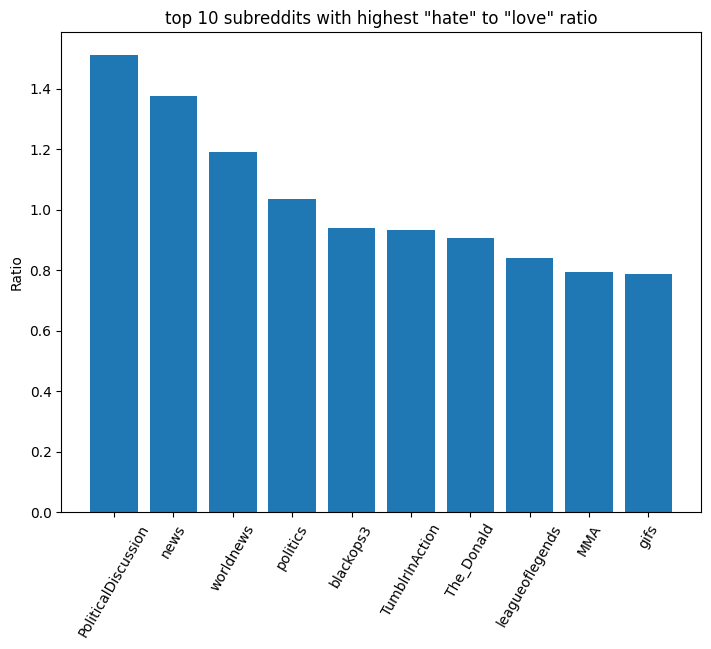

In [7]:
import matplotlib.pyplot as plt

#Plot the results for hate to love ratio

subreddit_hate_list = [row.subreddit for row in subreddits_hate]
hate_ratio_list = [row.hate_ratio for row in hate_ratio]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(subreddit_hate_list, rotation=60)
ax.bar(subreddit_hate_list, hate_ratio_list)
plt.title('top 10 subreddits with highest "hate" to "love" ratio')
plt.ylabel("Ratio")
plt.show()

/tmp/ipykernel_206914/2777973250.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subreddit_love_list, rotation=60)


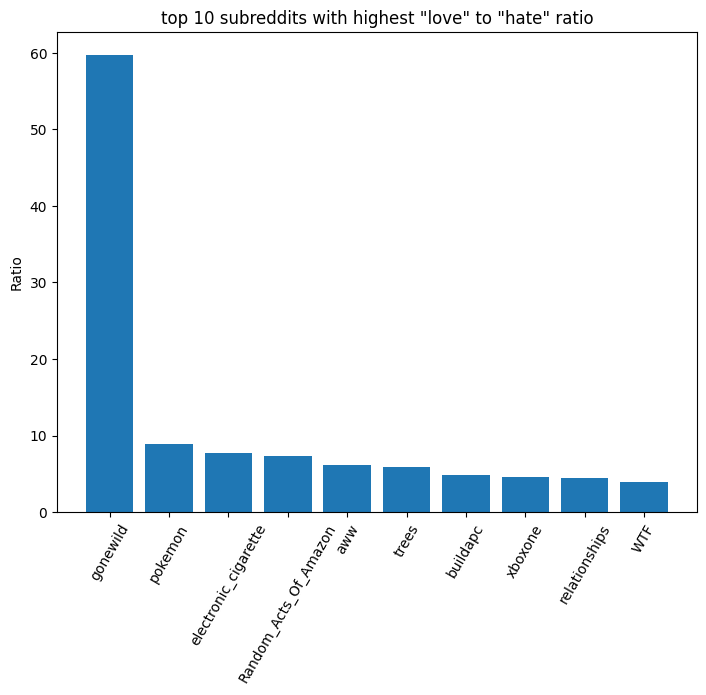

In [9]:
#Plot the results for love to hate ratio

subreddit_love_list = [row.subreddit for row in subreddits_love]
love_ratio_list = [row.love_ratio for row in love_ratio]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(subreddit_love_list, rotation=60)
ax.bar(subreddit_love_list, love_ratio_list)
plt.title('top 10 subreddits with highest "love" to "hate" ratio')
plt.ylabel("Ratio")
plt.show()

In [17]:
spark.stop()